In [1]:
cd ..

/Users/flamholz/Documents/workspace/ccm_evolution


In [2]:
mkdir -p figures/fig2

In [3]:
import numpy as np
import pandas as pd
import re
import seaborn as sns

from matplotlib import pyplot as plt

In [15]:
# Genes we want to plot - commenting out those that are not as interesting.
# TODO: make a configurable "to_plot" key
genes_of_interest = {
    'HNEAP_RS07320': dict(name='Crp/Fnr', kind='regulation'),
    'HNEAP_RS01030': dict(name='DAB2B', kind='transport'),
    'HNEAP_RS01035': dict(name='DAB2A', kind='transport'), 
    'HNEAP_RS04585': dict(name='DAB1B', kind='transport'),
    'HNEAP_RS04595': dict(name='DAB1A', kind='transport'),
    'HNEAP_RS01040': dict(name='LysR DAB2', kind='regulation'),
    'HNEAP_RS04645': dict(name='csosCA', kind='CA'),
    'HNEAP_RS04565': dict(name='csos1D', kind='carboxysome'),
    'HNEAP_RS04655': dict(name='cbbS', kind='carboxysome rubisco'),
    'HNEAP_RS04660': dict(name='cbbL', kind='carboxysome rubisco'),
    'HNEAP_RS04615': dict(name='acRAF', kind='chaperone'),
    'HNEAP_RS04625': dict(name='csos1A', kind='carboxysome'),
    'HNEAP_RS05490': dict(name='LysR', kind='regulation'),
    'HNEAP_RS04640': dict(name='csos4A', kind='carboxysome'),
    'HNEAP_RS04635': dict(name='csos4B', kind='carboxysome'),
    'HNEAP_RS04650': dict(name='csos2', kind='carboxysome'),
    'HNEAP_RS04630': dict(name='csos1C', kind='carboxysome'), 
    # Non-carboxysomal FII rubisco was named cbbM in Baker et al. JBac 1998.
    'HNEAP_RS05505': dict(name='cbbM', kind='non-carboxysomal rubisco'),
    'HNEAP_RS04600': dict(name='cbbO', kind='chaperone'),
    'HNEAP_RS04575': dict(name='cbbQ', kind='chaperone'),
}

categories2plot = {
    'transport': True,
    'carboxysome': True,
    'CA': True,
    'carboxysome rubisco': True,
    'regulation': False,
    'chaperone': False,
    'non-carboxysomal rubisco': False
}

locus2plot = [g for g, props in genes_of_interest.items()
              if categories2plot.get(props['kind'], False)]

barseq_df = pd.read_csv('data/Hnea/barseq/fit_logratios_all_good.csv')
barseq_df

,locus_id,5% CO2,ambient CO2,5% CO2.1,ambient CO2.1,0.5% CO2,10% CO2,0.5% CO2.1,10% CO2.1,1.5% CO2,5% CO2.2,1.5% CO2.1,5% CO2.3
0,GFF1190,-0.000402,0.021627,-0.001932,0.076393,-0.062972,-0.044107,-0.097597,-0.114159,0.039218,0.022432,0.003704,-0.027252
1,GFF1209,0.222629,-0.117649,-0.130837,-0.047011,-0.087761,-0.134193,0.154560,-0.038279,0.168402,0.069838,0.227850,-0.037395
2,GFF1357,-0.612701,-0.344187,-0.504753,-0.315189,-1.174064,-0.906337,-1.203053,-0.942894,-1.133942,-1.033053,-1.031073,-1.220323
3,GFF1439,-0.277288,-0.268327,-0.234944,-0.290411,0.117596,-0.007212,0.229604,0.198248,-0.147151,-0.079903,-0.161343,-0.110442
4,GFF1496,0.676934,0.320859,0.515599,0.189416,-0.795918,-0.274587,-0.364849,-0.181126,0.111388,-0.022536,-0.053180,-0.028839
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,HNEAP_RS12530,-0.027772,0.062316,-0.142976,-0.040603,0.123303,-0.002187,-0.124067,-0.115389,-0.066936,-0.057656,0.106591,0.084842
1724,HNEAP_RS12535,0.082261,0.042696,-0.150697,-0.186738,0.030698,0.249321,-0.207117,-0.179693,-0.193136,-0.260248,-0.041744,0.054070
1725,HNEAP_RS12550,-0.125825,0.017962,0.086862,0.037113,0.009698,-0.016191,-0.020960,0.047237,-0.011401,0.112636,0.156611,0.071176
1726,HNEAP_RS12555,-0.214570,-0.132329,-0.150477,-0.105451,-0.171533,-0.317492,0.079793,-0.091958,-0.124034,-0.003969,0.043375,-0.072267


In [12]:
# Make a long-form version of the barseq data as it's simpler for seaborn plotting.
numeric_cols = (barseq_df.dtypes == np.float64)
long_df = barseq_df.melt('locus_id', value_vars=barseq_df.columns[numeric_cols])

# Add categorical information.
default_props = dict(kind='other')
gene_tags = [genes_of_interest.get(row.locus_id, default_props)['kind'] 
             for _, row in long_df.iterrows()]

# Strip the .1 suffix in the condition name that comes from melt().
conds = [re.sub('CO2.\d+', 'CO2', row.variable) for _, row in long_df.iterrows()]
rep = [row.variable.split('.')[-1] for _, row in long_df.iterrows()]
long_df['gene_tag'] = gene_tags
long_df['cond'] = conds
long_df['rep'] = rep

# Shorter data frame for faster plotting of main-text genes.
mask = long_df.locus_id.isin(genes_of_interest.keys())
long_subset_df = long_df[mask]

long_subset_df.head()

,locus_id,variable,value,gene_tag,cond,rep
192,HNEAP_RS01030,5% CO2,-0.009401,transport,5% CO2,5% CO2
193,HNEAP_RS01035,5% CO2,0.052684,transport,5% CO2,5% CO2
194,HNEAP_RS01040,5% CO2,0.104180,regulation,5% CO2,5% CO2
648,HNEAP_RS04565,5% CO2,0.015781,carboxysome,5% CO2,5% CO2
650,HNEAP_RS04575,5% CO2,-0.129304,chaperone,5% CO2,5% CO2
...,...,...,...,...,...,...
19674,HNEAP_RS04655,5% CO2.3,-0.763467,carboxysome rubisco,5% CO2,3
19675,HNEAP_RS04660,5% CO2.3,-0.171117,carboxysome rubisco,5% CO2,3
19788,HNEAP_RS05490,5% CO2.3,0.175722,regulation,5% CO2,3
19791,HNEAP_RS05505,5% CO2.3,-0.682986,non-carboxysomal rubisco,5% CO2,3


In [14]:
long_subset_df.rep.unique()

array(['5% CO2', 'ambient CO2', '1', '10% CO2', '2', '3'], dtype=object)

In [10]:
# Calculate the IQR of fitness measurements for each of the CO2 conditions
median_fitness_series = long_df.groupby('cond').median()['value'].rename('median')
bot_fitness_series  = long_df.groupby('cond').quantile(0.25)['value'].rename('bottom')
top_fitness_series = long_df.groupby('cond').quantile(0.75)['value'].rename('top')
tmp = pd.concat([median_fitness_series, bot_fitness_series, top_fitness_series], axis=1)

# Across the whole dataset
median_fitness = long_df.value.median()
bot_quartile_fitness = long_df.value.quantile(0.25)
top_quartile_fitness = long_df.value.quantile(0.75)
print('Median fitness value over all experiments %.3g' % median_fitness)
print('IQR = (%.3g, %.3g)' % (bot_quartile_fitness, top_quartile_fitness))

print('Per CO2 condition')
tmp


Median fitness value over all experiments -0.0231
IQR = (-0.148, 0.0648)
Per CO2 condition


,median,bottom,top
cond,,,
0.5% CO2,-0.017437,-0.140040,0.077791
1.5% CO2,-0.033340,-0.170428,0.054025
10% CO2,-0.015358,-0.135522,0.073933
5% CO2,-0.027191,-0.149242,0.056724
ambient CO2,-0.021527,-0.147207,0.068630


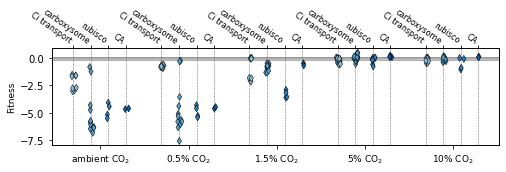

In [7]:
plt.figure(figsize=(7,2.5))
xorder = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,10% CO2'.split(',')
hue_order = 'transport,carboxysome,carboxysome rubisco,CA'.split(',')
pal = sns.color_palette('Blues')
greys = sns.color_palette('Greys')

sns.stripplot(data=long_subset_df, x='cond', y='value', hue='gene_tag', dodge=0.25,
              order=xorder, hue_order=hue_order,
              marker='d', edgecolor='k', linewidth=0.5, palette=pal[-4:])

ax = plt.gca()
bottom = [bot_quartile_fitness, bot_quartile_fitness]
top = [top_quartile_fitness, top_quartile_fitness]
plt.fill_between([0,1], bottom, top, color=greys[-3], alpha=0.5, transform=ax.get_yaxis_transform())
plt.axhline(median_fitness, lw=0.3, color=greys[-1])
plt.legend().set_visible(False)

xticks = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')
plt.xticks(np.arange(5), xticks, rotation=0, ha='center', fontsize=9)
plt.ylabel('Fitness', fontsize=9)
plt.xlabel('')

xticks = np.arange(0, 0.8, 0.2) - 0.31
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3, xticks+4])
xtick_str = 'Ci transport,carboxysome,rubisco,CA'.split(',')*5
for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])
    
ax = plt.gca()
axT = ax.twiny()
plt.sca(axT)

plt.xticks(xticks, xtick_str, ha='right', rotation=-35, fontsize=8)
plt.tick_params(pad=0)
plt.xlim(ax.get_xlim())

plt.tight_layout()
plt.savefig('figures/fig2/fig2.png', dpi=600, facecolor='w')
plt.show()

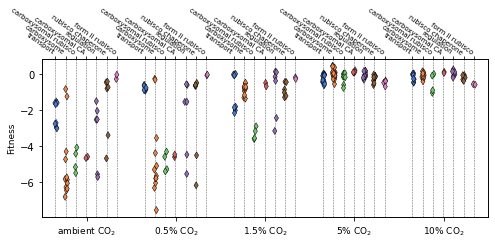

In [8]:
# Longer version of the main-text figure.
xorder = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,10% CO2'.split(',')
hue_order = 'transport,carboxysome,carboxysome rubisco,CA,regulation,chaperone,non-carboxysomal rubisco'.split(',')
pal = sns.color_palette('muted')
greys = sns.color_palette('Greys')

plt.figure(figsize=(7,3.5))
sns.stripplot(data=long_subset_df, x='cond', y='value', hue='gene_tag', dodge=0.25,
              order=xorder, hue_order=hue_order,
              marker='d', edgecolor='k', linewidth=0.5, palette=pal)
plt.legend().set_visible(False)

xticks = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')
plt.xticks(np.arange(5), xticks, rotation=0, ha='center', fontsize=9)
plt.ylabel('Fitness', fontsize=9)
plt.xlabel('')

xticks = np.arange(0, 0.7, 0.115) - 0.35
xticks = np.hstack([xticks, xticks+1, xticks+2, xticks+3, xticks+4])
xtick_str = 'transport,carboxysome,carboxysomal rubisco,carboxysomal CA,regulation,rubisco chaperone,form II rubisco'.split(',')*5
for xpos in xticks:
    plt.axvline(xpos, ls='--', lw=0.5, zorder=-1, color=greys[-2])
    
ax = plt.gca()
axT = ax.twiny()
plt.sca(axT)

plt.xlim(ax.get_xlim())
plt.xticks(xticks, xtick_str, ha='right', rotation=-35, fontsize=7)
plt.tick_params(pad=0)

plt.tight_layout()
plt.savefig('figures/fig2/fig2_S1.png', dpi=600, facecolor='w')
plt.show()

In [9]:
# Can't plot pairwise data with biological duplicates, so we take the mean fitness per-gene first.
mean_fitness_df = long_df.groupby(['locus_id', 'cond']).mean().reset_index()
mean_fitness_df = mean_fitness_df.pivot('locus_id', 'cond')['value']

# Add categorical information.
default_props = dict(kind='other')
gene_tags = [genes_of_interest.get(locus_id, default_props)['kind'] 
             for locus_id, row in mean_fitness_df.iterrows()]
mean_fitness_df['gene_tag'] = gene_tags

mean_fitness_df.head()

cond,0.5% CO2,1.5% CO2,10% CO2,5% CO2,ambient CO2,gene_tag
locus_id,,,,,,
GFF1190,-0.080285,0.021461,-0.079133,-0.001788,0.049010,other
GFF1209,0.033399,0.198126,-0.086236,0.031059,-0.082330,other
GFF1357,-1.188559,-1.082507,-0.924616,-0.842707,-0.329688,other
GFF1439,0.173600,-0.154247,0.095518,-0.175644,-0.279369,other
GFF1496,-0.580384,0.029104,-0.227856,0.285289,0.255138,other


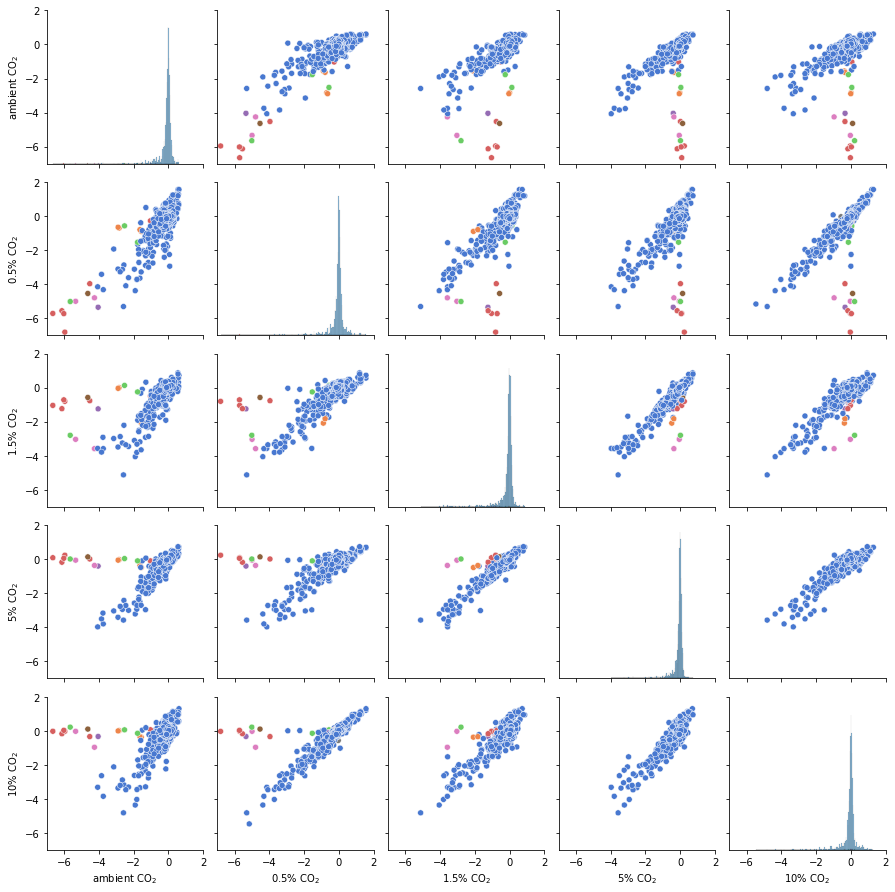

In [10]:
co2_order = 'ambient CO2,0.5% CO2,1.5% CO2,5% CO2,10% CO2'.split(',')
co2_labels = 'ambient CO$_2$,0.5% CO$_2$,1.5% CO$_2$,5% CO$_2$,10% CO$_2$'.split(',')

pal = sns.color_palette('muted', n_colors=8)
g = sns.PairGrid(mean_fitness_df, vars=co2_order, hue='gene_tag')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, palette=pal)
g.set(ylim=(-7, 2), xlim=(-7, 2))

for ylabel, ax in zip(co2_labels, g.axes[:,0]):
    ax.set_ylabel(ylabel)
for xlabel, ax in zip(co2_labels, g.axes[-1,:]):
    ax.set_xlabel(xlabel)

plt.tight_layout()
plt.savefig('figures/fig2/fig2_S2.png', dpi=600, facecolor='w')
plt.show()

In [11]:
sns.stripplot?

Signature:
sns.stripplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    jitter=True,
    dodge=False,
    orient=None,
    color=None,
    palette=None,
    size=5,
    edgecolor='gray',
    linewidth=0,
    ax=None,
    **kwargs,
)
Docstring:
Draw a scatterplot where one variable is categorical.

A strip plot can be drawn on its own, but it is also a good complement
to a box or violin plot in cases where you want to show all observations
along with some representation of the underlying distribution.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A "long-form" DataFrame, in which case the ``x``, ``y``, and ``hue``
  variables will determine how the data are plotted.
- A "wide-form" DataFrame, such that each numeric column will be plotted.
- An array or list of vectors.

I